In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_path = '/Users/ibrahimhasan/Documents/ftds009/final project/meat'

In [ ]:
train_dir = os.path.join(main_path, 'train')

In [ ]:
print('train set: \n' + '='*50)
num_fresh= len(os.listdir(os.path.join(train_dir, 'Fresh')))
num_spoiled= len(os.listdir(os.path.join(train_dir, 'Spoiled')))
print(f'fresh = {num_fresh}', 'images')
print(f'spoiled = {num_spoiled}', 'images')

train set: 
fresh = 948 images
spoiled = 948 images


In [ ]:
train_fresh = glob.glob(train_dir+"/Fresh/*.jpg")
train_spoiled = glob.glob(train_dir+"/Spoiled/*.jpg")

In [ ]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_fresh + train_spoiled)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
print(train_df.shape)
train_df.head()

(1896, 2)


,images,label
0,/Users/ibrahimhasan/Documents/ftds009/final pr...,Fresh
1,/Users/ibrahimhasan/Documents/ftds009/final pr...,Fresh
2,/Users/ibrahimhasan/Documents/ftds009/final pr...,Fresh
3,/Users/ibrahimhasan/Documents/ftds009/final pr...,Fresh
4,/Users/ibrahimhasan/Documents/ftds009/final pr...,Fresh


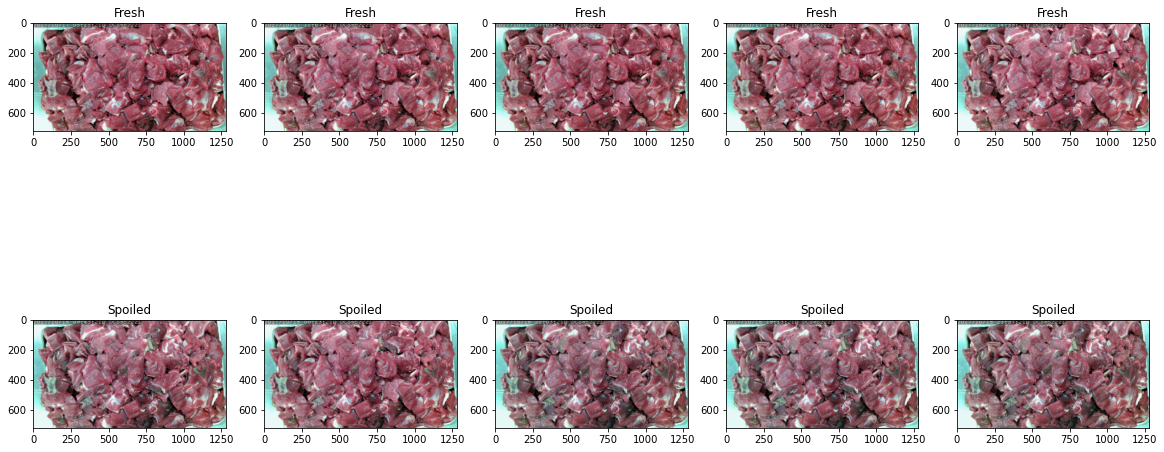

In [ ]:
# Get few samples for both the classes
fresh_samples = (train_df[train_df['label']=="Fresh"]['images'].iloc[:5]).tolist()
spoiled_samples = (train_df[train_df['label']=='Spoiled']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(fresh_samples + spoiled_samples)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(1516, 2)
(380, 2)


In [ ]:
img_height= 170
img_width= 170
SEED = 1
BATCH = 128

In [ ]:
train_datagen_pipe = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
ds_train_pipe = train_datagen_pipe.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_val_pipe = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 1516 validated image filenames belonging to 2 classes.
Found 380 validated image filenames belonging to 2 classes.


In [ ]:
inputs_sz = [img_height,img_width,3]

In [ ]:
model_2= Sequential()

#Conv 1, 
model_2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape=(inputs_sz)))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model_2.add(Conv2D(filters=90, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model_2.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 4
model_2.add(Conv2D(filters=256, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

model_2.add(Flatten())
model_2.add(Dense(units=380 , activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))

2022-05-08 00:23:24.106745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 168, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 84, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 90)        51930     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 90)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       103808    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 128)      0

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
history_2 = model_2.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val_pipe)

Epoch 1/10
12/12 [==============================] - 104s 9s/step - loss: 0.8116 - accuracy: 0.4993 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 97s 8s/step - loss: 0.6946 - accuracy: 0.5198 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 3/10
12/12 [==============================] - 90s 7s/step - loss: 0.6477 - accuracy: 0.6135 - val_loss: 0.4770 - val_accuracy: 0.9289
Epoch 4/10
12/12 [==============================] - 94s 8s/step - loss: 0.7066 - accuracy: 0.5851 - val_loss: 0.6547 - val_accuracy: 0.5000
Epoch 5/10
12/12 [==============================] - 91s 7s/step - loss: 0.5249 - accuracy: 0.7381 - val_loss: 0.3910 - val_accuracy: 0.7842
Epoch 6/10
12/12 [==============================] - 91s 7s/step - loss: 0.3908 - accuracy: 0.8278 - val_loss: 0.4575 - val_accuracy: 0.7816
Epoch 7/10
12/12 [==============================] - 90s 7s/step - loss: 0.2848 - accuracy: 0.8773 - val_loss: 0.1479 - val_accuracy: 0.9474
Epoch 8/10
12/12 [=

In [ ]:
y_true = ds_val_pipe.classes

In [ ]:
test_pred = model_2.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       190
           1       1.00      0.66      0.80       190

    accuracy                           0.83       380
   macro avg       0.87      0.83      0.83       380
weighted avg       0.87      0.83      0.83       380



In [ ]:
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', \
                                                  input_shape=(224,224,3), pooling='avg')
pretrained_model.trainable = False

In [ ]:
model_pr = Sequential()
model_pr.add(pretrained_model)
model_pr.add(Flatten())
model_pr.add(Dense(128, activation='relu'))
model_pr.add(Dense(1, activation='sigmoid'))

In [ ]:
model_pr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
model_pr.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
history_pr = model_pr.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 13, validation_data= ds_val_pipe)

Epoch 1/13
12/12 [==============================] - 138s 11s/step - loss: 0.6869 - accuracy: 0.5897 - val_loss: 0.5980 - val_accuracy: 0.5000
Epoch 2/13
12/12 [==============================] - 138s 12s/step - loss: 0.4853 - accuracy: 0.7922 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 3/13
12/12 [==============================] - 128s 11s/step - loss: 0.3617 - accuracy: 0.8615 - val_loss: 0.4153 - val_accuracy: 0.7237
Epoch 4/13
12/12 [==============================] - 117s 10s/step - loss: 0.2805 - accuracy: 0.8964 - val_loss: 0.2336 - val_accuracy: 0.9289
Epoch 5/13
12/12 [==============================] - 120s 10s/step - loss: 0.2534 - accuracy: 0.8958 - val_loss: 0.2639 - val_accuracy: 0.8842
Epoch 6/13
12/12 [==============================] - 118s 10s/step - loss: 0.2265 - accuracy: 0.9103 - val_loss: 0.3411 - val_accuracy: 0.8158
Epoch 7/13
12/12 [==============================] - 119s 10s/step - loss: 0.2163 - accuracy: 0.9156 - val_loss: 0.2147 - val_accuracy: 0.9132
Epoch 

In [ ]:
test_pred = model_pr.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       190
           1       1.00      0.61      0.75       190

    accuracy                           0.80       380
   macro avg       0.86      0.80      0.79       380
weighted avg       0.86      0.80      0.79       380



In [ ]:
model_3= Sequential()

#Conv 1, 
model_3.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape=(inputs_sz)))
model_3.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model_3.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model_3.add(MaxPooling2D(pool_size=2, strides=2))

model_3.add(Flatten())
model_3.add(Dense(units=64 , activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 168, 168, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 84, 84, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 82, 82, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 41, 41, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 215168)            0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
history_3 = model_3.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val_pipe)

Epoch 1/10
12/12 [==============================] - 115s 9s/step - loss: 1.7385 - accuracy: 0.4828 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 96s 8s/step - loss: 0.6663 - accuracy: 0.5343 - val_loss: 0.6369 - val_accuracy: 0.5000
Epoch 3/10
12/12 [==============================] - 97s 8s/step - loss: 0.5413 - accuracy: 0.7381 - val_loss: 0.3779 - val_accuracy: 0.9289
Epoch 4/10
12/12 [==============================] - 96s 8s/step - loss: 0.4076 - accuracy: 0.8080 - val_loss: 0.3761 - val_accuracy: 0.8447
Epoch 5/10
12/12 [==============================] - 98s 8s/step - loss: 0.3152 - accuracy: 0.8549 - val_loss: 0.2563 - val_accuracy: 0.8658
Epoch 6/10
12/12 [==============================] - 98s 8s/step - loss: 0.2365 - accuracy: 0.9070 - val_loss: 0.2041 - val_accuracy: 0.9237
Epoch 7/10
12/12 [==============================] - 93s 8s/step - loss: 0.2083 - accuracy: 0.9129 - val_loss: 0.1082 - val_accuracy: 0.9737
Epoch 8/10
12/12 [=

In [ ]:
test_pred = model_3.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       190
           1       0.98      0.97      0.97       190

    accuracy                           0.97       380
   macro avg       0.97      0.97      0.97       380
weighted avg       0.97      0.97      0.97       380



In [ ]:
metrics_model_3 = pd.DataFrame(history_3.history)
metrics_model_3.head()

,loss,accuracy,val_loss,val_accuracy
0,1.738455,0.482850,0.684286,0.500000
1,0.666250,0.534301,0.636862,0.500000
2,0.541287,0.738127,0.377883,0.928947
3,0.407587,0.808047,0.376084,0.844737
4,0.315236,0.854881,0.256274,0.865789


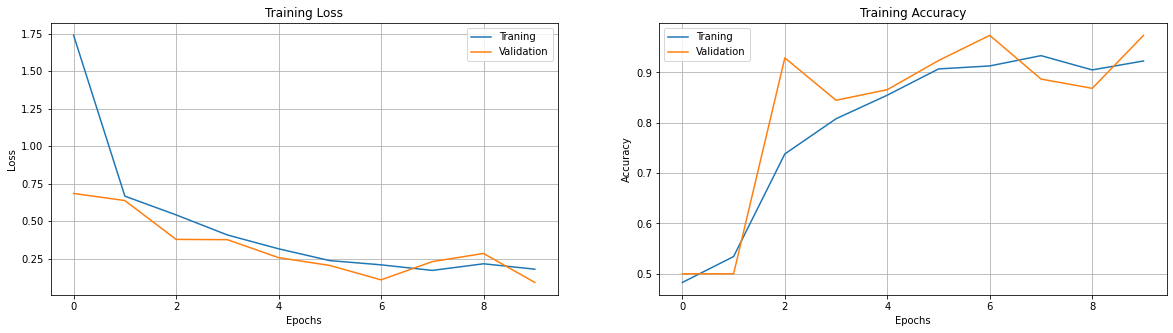

In [ ]:
# Plot Training Loss
ig, ax = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(metrics_model_3.index, metrics_model_3['loss'], label='Traning')
plt.plot(metrics_model_3.index, metrics_model_3['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy Loss
plt.subplot(1,2,2)
plt.plot(metrics_model_3.index, metrics_model_3['accuracy'], label='Traning')
plt.plot(metrics_model_3.index, metrics_model_3['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [ ]:
ds_train_pipe.class_indices

{'Fresh': 0, 'Spoiled': 1}

In [ ]:
THRESHOLD = 0.5
y_pred_class = (test_pred >= THRESHOLD).reshape(-1,)
y_true = ds_val_pipe.classes

pd.DataFrame(
    confusion_matrix(y_true, y_pred_class),
    index = [["Actual", "Actual"], ["fresh", "spoiled"]],
    columns = [["Predicted", "Predicted"], ["fresh", "spoiled"]])

Predicted        
                   fresh spoiled
Actual fresh         186       4
       spoiled         6     184

In [ ]:
model_3.save('model_meat.h5')